In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

In [13]:
def prepare_lstm_data(df, target_col='Close', sequence_length=60):
    """
    Prepare data for LSTM model by creating sequences
    
    Parameters:
    df (DataFrame): Input dataframe with features
    target_col (str): Column to predict
    sequence_length (int): Number of time steps to use for sequences
    
    Returns:
    tuple: (X_train, y_train, X_test, y_test, scalers)
    """
    print("\n==== Preparing Data for LSTM Model ====")
    
    # Get list of features to use (numeric columns)
    feature_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove any derived features that use future information to avoid data leakage
    features_to_exclude = [
        'price_change_pct', 'price_change', 'returns',  # These are based on future Close prices
        'momentum_5d', 'momentum_10d', 'momentum_20d'   # These look ahead in time
    ]
    
    feature_columns = [col for col in feature_columns if col not in features_to_exclude]
    
    # Make sure target is in features
    if target_col not in feature_columns:
        feature_columns.append(target_col)
    
    print(f"Using {len(feature_columns)} features: {feature_columns[:5]}...")
    
    # Create a new dataframe with selected features, dropping NaN rows
    data = df[feature_columns].dropna()
    
    # Split into training and test sets (70% train, 30% test)
    train_size = int(len(data) * 0.7)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    
    # Normalize the data - store scalers for later inverse transformation
    scalers = {}
    train_scaled = pd.DataFrame()
    test_scaled = pd.DataFrame()
    
    for column in feature_columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Fit scaler on training data
        train_scaled[column] = scaler.fit_transform(train_data[column].values.reshape(-1, 1)).flatten()
        # Transform test data with the same scaler
        test_scaled[column] = scaler.transform(test_data[column].values.reshape(-1, 1)).flatten()
        # Store scaler for inverse transformation later
        scalers[column] = scaler

            # Create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            # Extract sequence of features
            seq_x = data.iloc[i:(i + seq_length)].values
            # Extract target
            seq_y = data.iloc[i + seq_length][target_col]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    
    # Generate training sequences
    X_train, y_train = create_sequences(train_scaled, sequence_length)
    # Generate test sequences
    X_test, y_test = create_sequences(test_scaled, sequence_length)
    
    print(f"Training sequences shape: {X_train.shape}")
    print(f"Test sequences shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, scalers

In [14]:
def build_lstm_model(input_shape):
    """
    Build LSTM model architecture
    
    Parameters:
    input_shape (tuple): Shape of input data (sequence_length, features)
    
    Returns:
    model: Compiled LSTM model
    """
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense layers for prediction
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    
    return model

In [15]:
def train_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Train the LSTM model
    
    Parameters:
    X_train, y_train, X_test, y_test: Training and test data
    epochs (int): Number of training epochs
    batch_size (int): Training batch size
    
    Returns:
    model: Trained model
    history: Training history
    """
    print("\n==== Training LSTM Model ====")
    
    # Get input shape from training data
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

In [16]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scalers, target_col='Close'):
    """
    Evaluate the LSTM model performance
    
    Parameters:
    model: Trained LSTM model
    X_train, y_train, X_test, y_test: Training and test data
    scalers (dict): Dictionary of scalers for each feature
    target_col (str): Target column name
    
    Returns:
    tuple: (train_predictions, test_predictions, metrics)
    """
    print("\n==== Evaluating Model Performance ====")
    
    # Get target scaler for inverse transformation
    scaler = scalers[target_col]
    
    # Make predictions
    train_predictions_scaled = model.predict(X_train)
    test_predictions_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values to original scale
    train_predictions = scaler.inverse_transform(train_predictions_scaled)
    test_predictions = scaler.inverse_transform(test_predictions_scaled)
    
    # Transform the original y values back to original scale
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics - make sure arrays are the same length
    train_rmse = math.sqrt(mean_squared_error(y_train_orig, train_predictions))
    test_rmse = math.sqrt(mean_squared_error(y_test_orig, test_predictions))
    
    train_mae = mean_absolute_error(y_train_orig, train_predictions)
    test_mae = mean_absolute_error(y_test_orig, test_predictions)
    
    train_r2 = r2_score(y_train_orig, train_predictions)
    test_r2 = r2_score(y_test_orig, test_predictions)
    
    # Store metrics in dictionary
    metrics = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    # Print metrics
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    return train_predictions, test_predictions, metrics

In [17]:
def visualize_predictions(df, train_predictions, test_predictions, sequence_length=60, target_col='Close'):
    """
    Visualize model predictions against actual prices
    
    Parameters:
    df (DataFrame): Original dataframe
    train_predictions, test_predictions: Model predictions
    sequence_length (int): Sequence length used for LSTM
    target_col (str): Target column name
    """
    print("\n==== Visualizing Predictions ====")
    
    plt.figure(figsize=(16, 8))
    
    # Plot actual data
    plt.plot(df.index, df[target_col], color='blue', label=f'Actual {target_col} Price')
    
    # Calculate indices for predictions
    train_size = int(len(df) * 0.7)
    
    # For training predictions: need to offset by sequence_length
    train_start_idx = sequence_length
    train_end_idx = train_size
    train_plot_indices = df.index[train_start_idx:train_end_idx]
    
    # For test predictions: need to start after train data
    test_start_idx = train_size + sequence_length
    test_end_idx = test_start_idx + len(test_predictions)
    
    # Make sure test_end_idx doesn't exceed dataframe length
    test_end_idx = min(test_end_idx, len(df))
    test_predictions = test_predictions[:test_end_idx - test_start_idx]  # Adjust predictions length
    
    test_plot_indices = df.index[test_start_idx:test_end_idx]
    
    # Plot predictions - only if we have valid indices
    if len(train_plot_indices) > 0 and len(train_predictions) > 0:
        # Make sure lengths match
        min_train_len = min(len(train_plot_indices), len(train_predictions))
        plt.plot(train_plot_indices[:min_train_len], train_predictions[:min_train_len].flatten(), 
                 color='green', label=f'Training Predictions')
    
    if len(test_plot_indices) > 0 and len(test_predictions) > 0:
        # Make sure lengths match
        min_test_len = min(len(test_plot_indices), len(test_predictions))
        plt.plot(test_plot_indices[:min_test_len], test_predictions[:min_test_len].flatten(), 
                 color='red', label=f'Test Predictions')
    
    plt.title(f'NVIDIA {target_col} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{target_col} Price ($)')
    plt.legend()
    plt.grid(True)
    
    plt.savefig('nvidia_stock_prediction.png')
    plt.show()
    
    # Plot loss during training if history is available
    try:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss During Training')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        
        plt.savefig('nvidia_training_loss.png')
        plt.show()
    except NameError:
        print("Training history not available for plotting")

In [18]:
def predict_lstm(df, target_col='Close', sequence_length=60, epochs=50, batch_size=32):
    """
    Main function to run LSTM prediction on stock data
    
    Parameters:
    df (DataFrame): Processed dataframe with features
    target_col (str): Column to predict (default: 'Close')
    sequence_length (int): Number of time steps for sequences (default: 60)
    epochs (int): Maximum training epochs (default: 50)
    batch_size (int): Training batch size (default: 32)
    
    Returns:
    tuple: (model, metrics, predictions)
    """
    # Prepare data
    X_train, y_train, X_test, y_test, scalers = prepare_lstm_data(
        df, target_col=target_col, sequence_length=sequence_length
    )
    
    # Train model
    global model, history
    model, history = train_lstm_model(
        X_train, y_train, X_test, y_test, 
        epochs=epochs, batch_size=batch_size
    )
    
    # Evaluate model
    train_predictions, test_predictions, metrics = evaluate_model(
        model, X_train, y_train, X_test, y_test, scalers, target_col
    )
    
    # Visualize results
    visualize_predictions(df, train_predictions, test_predictions, sequence_length, target_col)
    
    # Save model if needed
    model.save('nvidia_lstm_model.h5')
    print("Model saved as 'nvidia_lstm_model.h5'")
    
    return model, metrics, test_predictions


==== Preparing Data for LSTM Model ====
Using 31 features: ['calendarYear', 'revenue', 'grossProfit', 'netIncome', 'operatingIncome']...
Train data shape: (889, 31), Test data shape: (381, 31)
Training sequences shape: (829, 60, 31)
Test sequences shape: (321, 60, 31)

==== Training LSTM Model ====


c:\Users\lukis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,901 (148.05 KB)

 Trainable params: 37,901 (148.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0396 - val_loss: 3.0360
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0064 - val_loss: 2.5743
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0049 - val_loss: 2.4357
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039 - val_loss: 2.2061
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033 - val_loss: 2.0874
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0034 - val_loss: 2.2688
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025 - val_loss: 1.9944
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026 - val_loss: 2.1264
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 1.9905
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0021 - val_loss: 1.9464
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0023 - val_loss: 2.0022
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

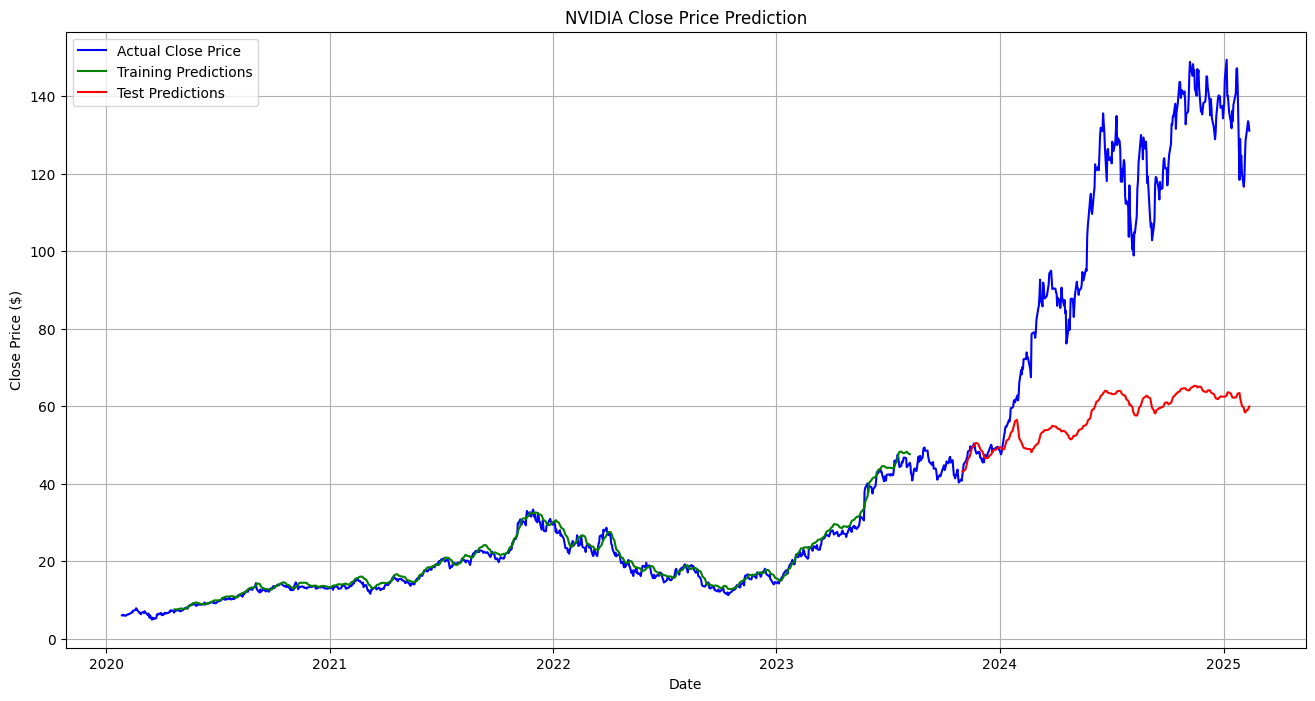

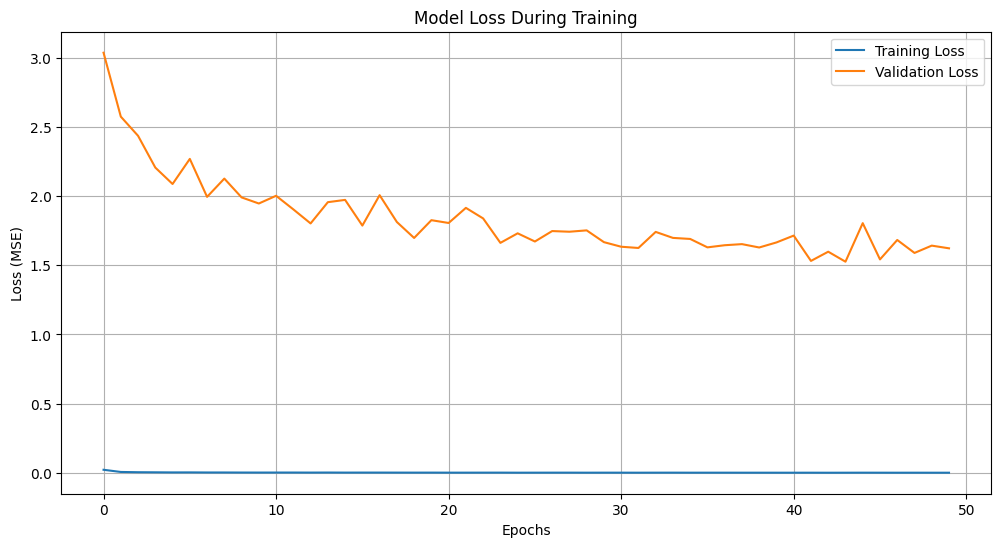

Model saved as 'nvidia_lstm_model.h5'

==== Prediction Complete ====
Model metrics: {'train_rmse': 1.2913901750188588, 'test_rmse': 52.603643456353744, 'train_mae': 0.9830407538373738, 'test_mae': 45.333803194705574, 'train_r2': 0.9761515212932912, 'test_r2': -1.6042804595580837}
Test predictions shape: (321, 1)


In [19]:
# Example usage with the processed dataframe from your previous code
if __name__ == "__main__":
    # Assuming 'enhanced_df' is the output from your previous processing
    # You can load it from the saved CSV or use the result from the previous function
    enhanced_df = pd.read_csv("nvda_merged_dataset.csv")
    
    # Convert Date back to datetime
    enhanced_df['Date'] = pd.to_datetime(enhanced_df['Date'])
    
    # Set Date as index for easier time series analysis
    enhanced_df.set_index('Date', inplace=True)
    
    # Run LSTM prediction
    model, metrics, predictions = predict_lstm(
        enhanced_df, 
        target_col='Close',
        sequence_length=60,  # 60 days of history
        epochs=50,
        batch_size=32
    )
    
    print("\n==== Prediction Complete ====")
    print(f"Model metrics: {metrics}")
    print(f"Test predictions shape: {predictions.shape}")